<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/05.03-Lunar-Lander-Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
try: 
  import control as ct
except:
  !pip install control
  import control as ct

# Lunar lander control

We now create an input/output model for the lunar lander that takes the main engine thurst $F_t$ and the lateral engine thurst $F_l$ as inputs and outputs the horizontal position $p_x$, the horizontal speed $v_x$, the vertical position $p_y$, the vertical speed $v_y$, the heading $\theta$, the heading speed $v_\theta$, the total mass $m_t$ and the fuel mass $m_f$.

This model is coded [here](https://github.com/gmxavier/FAT0413150/blob/main/src/dynamic_models.py) and to do everything we will need to run the cell below.



In [2]:
# To get the file
from requests import get
repo_url = 'https://raw.githubusercontent.com/gmxavier/FAT0413150/main/'
for file in ['dynamic_models.py']:
  url = repo_url+'src/'+file
  with open(file, 'w') as f: 
    f.write(get(url).text)

# To load it and import the model update function
%load dynamic_models.py
from dynamic_models import lunar_update

# To create an input/output model
lunar = ct.NonlinearIOSystem(lunar_update, 
                             None, 
                             inputs  = ('F_t', 'F_l'), 
                             outputs = ('p_x', 'v_x', 'p_y', 'v_y', 'theta', 'v_theta', 'm_t', 'm_f'), 
                             states  = ('p_x', 'v_x', 'p_y', 'v_y', 'theta', 'v_theta', 'm_t', 'm_f'), 
                             name    = 'lunar')

Next we define a function for creating a "standard" landing control plot.

In [6]:
def landing_plot(sys, T, u, x0):

  t, y = ct.input_output_response(sys, T, u, x0)

  xlabel = 'Time $t$ [s]'
  ylabel = ['Main engine thrust $F_t$ [kN]',
            'Lateral engine thrust $F_l$ [kN]',
            'Horizontal position $p_x$ [km]',
            'Horizontal speed $v_x$ [m/s]',
            'Vertical position $p_y$ [km]',
            'Vertical speed $v_y$ [m/s]',
            'Heading $\\theta$ [rad]',
            'Heading speed $v_\\theta$ [rad/s]',
            'Total mass $m_t$ [Mg]',
            'Fuel mass $m_t$ [Mg]'
            ]

  fig, axes = plt.subplots(5, 2, figsize=(22, 22))
  axe = axes.ravel()

  for k, ax in enumerate(axe):
    scale = 1e3 if k in [0,1,2,4,8,9] else 1
    if k in [0,1]:
      ax.plot(t, u[k]/scale)
    else:
      ax.plot(t, y[k-2]/scale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel[k])
    ax.grid(True, linestyle='dotted')
  
  return t, y

## PD Controller

Let's try the following PD controller for the vertical position $p_y$.

In [13]:
gain_P = -11
gain_D = -2350
p_y_P = ct.tf2io(ct.tf(gain_P, 1), inputs='p_y', outputs='u_p')
p_y_D = ct.tf2io(ct.tf(gain_D, 1), inputs='v_y', outputs='u_d')
sumblk = ct.summing_junction(inputs=['u_p', 'u_d'], output='F_t')

Now let's build the closed loop control system, setup the simulation and see what happens.

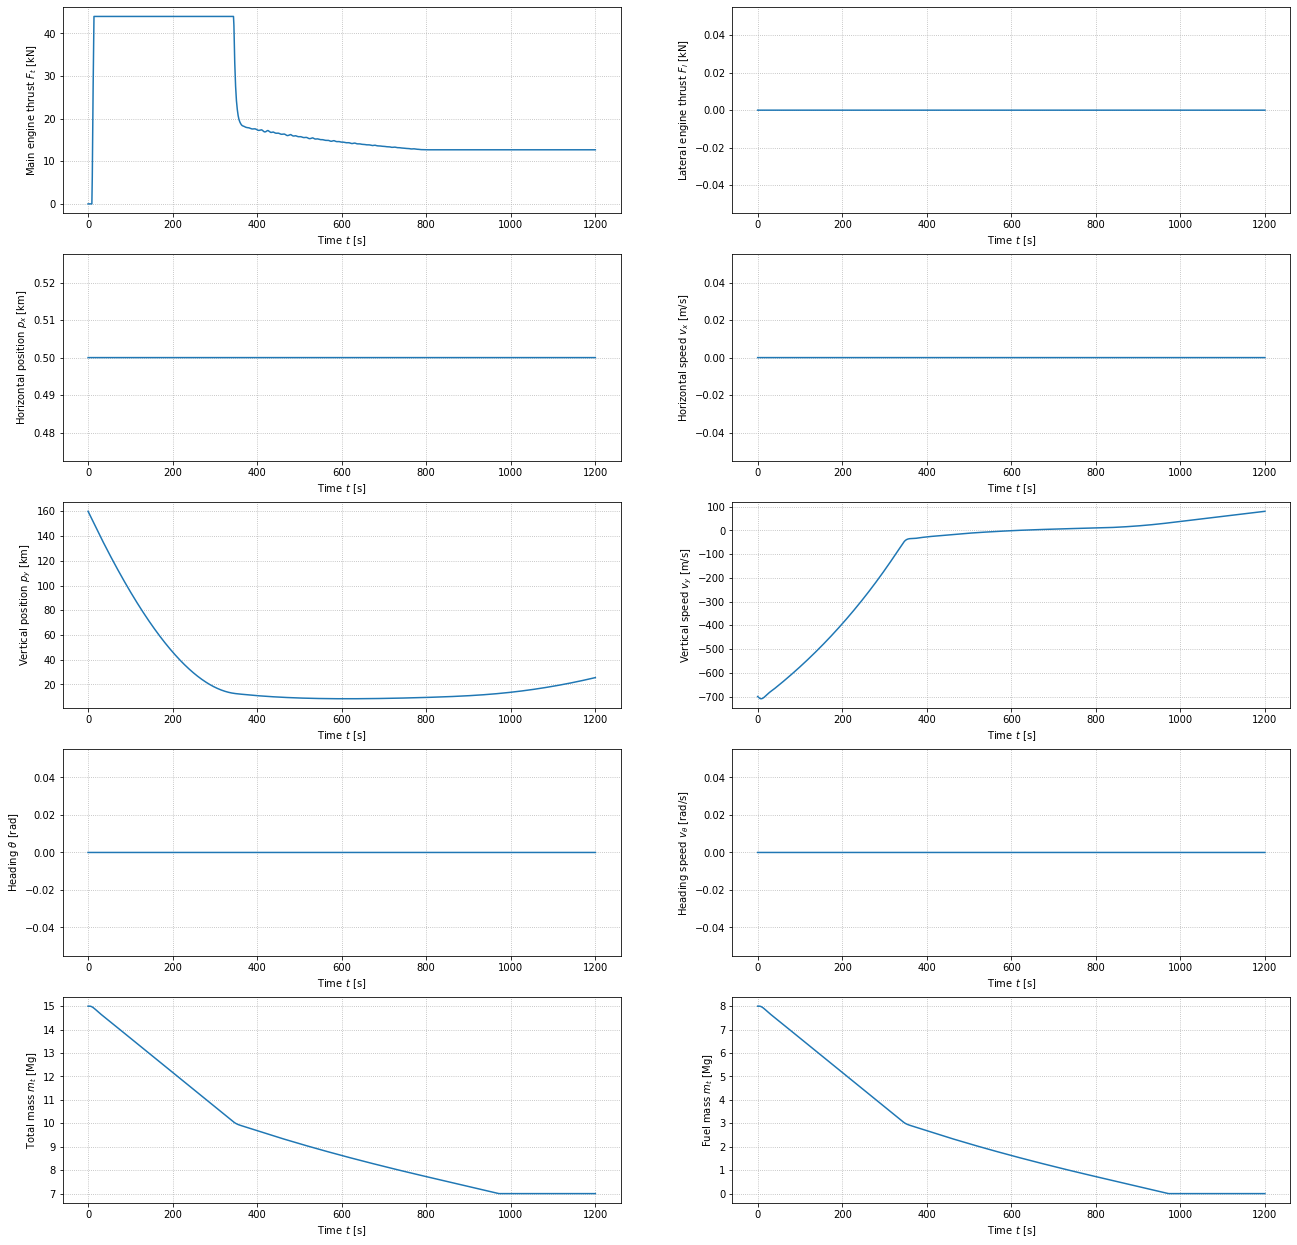

In [17]:
# Closed loop control system
land = ct.interconnect([lunar, p_y_P, p_y_D, sumblk], 
                       inplist=('F_l'), 
                       outlist=('F_t', 'p_x', 'v_x', 'p_y', 'v_y', 'theta', 'v_theta', 'm_t', 'm_f'))
# Initial conditions
X0 = [0.5e+03, 0.0, 160.0e+03, -0.7e+03, 0.0, 0.0, 15.0e+03, 8.0e+03]
# Total simulation time
tst = 1200
# Simulation time array
T  = np.linspace(0, tst, tst+1)
# Input
F_l  = np.array([0.0 for t in T])
# Simulate and plot
t, y = ct.input_output_response(land, T, F_l, X0)
F_t = np.clip(y[0], 0, 44e3)
t, y = landing_plot(lunar, T, [F_t, F_l], X0)

In [144]:
y[2][999]

14346.549704851821